获取 Mnist数据集

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

转换数据集的类型，数据需要转换成 tensor 才能进行后续训练

In [2]:
import torch

def show_dtype():
    print(x_train.shape, type(x_train))
    print(y_train.shape, type(y_train))
    print(x_valid.shape, type(x_valid))
    print(y_valid.shape, type(y_valid))
show_dtype()
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
show_dtype()

(50000, 784) <class 'numpy.ndarray'>
(50000,) <class 'numpy.ndarray'>
(10000, 784) <class 'numpy.ndarray'>
(10000,) <class 'numpy.ndarray'>
torch.Size([50000, 784]) <class 'torch.Tensor'>
torch.Size([50000]) <class 'torch.Tensor'>
torch.Size([10000, 784]) <class 'torch.Tensor'>
torch.Size([10000]) <class 'torch.Tensor'>


使用matplotlib输出原始图像

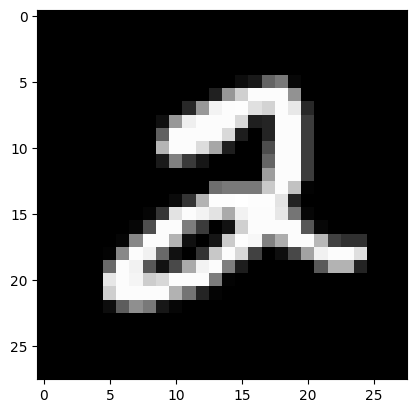

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

img = x_train[5].reshape((28, 28))
plt.imshow(img, cmap="gray")

试试使用交叉熵函数计算损失值

In [4]:
import torch.nn.functional as F

# 损失函数
loss_func = F.cross_entropy

def model1(x):
    return x.mm(weights) + bias

# 随机初始化一组权重参数，大小、类型和是否可以更新
weights = torch.randn([784, 10], dtype=torch.float, requires_grad=True)
# 初始值全为 0 的偏置项，可以更新
bias = torch.zeros(10, requires_grad=True)

batch_size = 64
x_b = x_train[:batch_size]
y_b = y_train[:batch_size]
print(x_b.shape)
print(y_b.shape)
print()

pre = model1(x_b)
print(pre.shape)
print(y_b.shape)
print()

loss_value = loss_func(pre, y_b)
print(loss_value)

torch.Size([64, 784])
torch.Size([64])

torch.Size([64, 10])
torch.Size([64])

tensor(11.6078, grad_fn=<NllLossBackward0>)


定义神经网络

In [9]:
from torch import nn

# 继承
class Nn(nn.Module):
    def __init__(self):
        super().__init__()
        # 定义隐藏层
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 256)
        # 定义输出，进行的是十分类
        self.out = nn.Linear(256, 10)
        # 定义，作用是丢弃部分神经元，避免过度依赖训练集中的噪声
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        """前向传播"""
        x = F.relu(self.hidden1(x))
        # print(x.shape)
        # dropout 不会改变输出的维度
        x = self.dropout(x)
        x = F.relu(self.hidden2(x))
        # print(x.shape)
        x = self.dropout(x)
        return x

# # 查看定义的神经网络自己随机初始化的权重和偏置项
# net = Nn()
# for name, parameter in net.named_parameters():
#     # print(name, parameter.shape)
#     pass

定义数据集

In [6]:
from torch.utils.data import TensorDataset, DataLoader

# 封装成数据集：像素点 + 标签 组成一份数据，共 50000份
train_ds = TensorDataset(x_train, y_train)
# 从封装好的数据集中加载指定份（64份）数据进行打包
# shuffle 为 True，意味着要先打乱样本然后再打包成批次（batch）
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# 验证的数据集就没必要打乱了
valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [7]:
# 定义成函数
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs*2)
    )

定义一个函数：获取 神经网络 和 优化器

In [8]:
from torch import optim

def get_model():
    # 实例化神经网络
    model = Nn()
    # 返回值中包括优化器--梯度下降
    # 梯度下降函数中的 参数model.parameters() 表示更新时要更新所有的权重参数（即 weights 和 bias）
    # 学习率决定了每次参数更新的步长大小
    return model, optim.Adam(model.parameters(), lr=0.001)

定义一个函数：可以只计算损失值，也可以进行反向传播

In [9]:
# 计算损失值，可选择是否对模型进行更新
def loss_batch(model, loss_func, xb, yb, opt=None):
    # 计算损失值
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()  # 计算梯度
        opt.step()       # 按构建时的参数来更新权重参数
        opt.zero_grad()  # 将旧的参数清零了

    # 反向传播是直接更新权重矩阵的，不需要返回值
    
    # loss.item()：计算损失值转为 python基本数值类型（float）
    # len(xb)：样本数量
    return loss.item(), len(xb)

现在有 神经网络（包含前向传播）、优化器、数据集 和 反向传播，接下来进行训练模型

In [10]:
import numpy as np

def fit(steps, model, opt, loss_func, train_dl, valid_dl):
    for step in range(steps):
        # 训练模式
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        # 验证模式
        model.eval()
        # 在 torch.no_grad() 块内，所有涉及 requires_grad=True 张量的操作都不会生成计算图，也不会存储中间梯度
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
            # 总损失 / 总样本数
            val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            print("当前step：" + str(step), "验证集损失：" + str(val_loss))

运行模型

In [11]:
steps = 100

model, opt = get_model()

loss_func = F.cross_entropy

batch_size = 128
train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)

fit(steps, model, opt, loss_func, train_dl, valid_dl)

当前step：0 验证集损失：1.8169410785675049
当前step：1 验证集损失：1.450779263305664
当前step：2 验证集损失：1.3596630800247191
当前step：3 验证集损失：1.2637135103225707
当前step：4 验证集损失：1.1502763191223144
当前step：5 验证集损失：1.0406708005905152
当前step：6 验证集损失：1.0379441184997558
当前step：7 验证集损失：1.0035137592315675
当前step：8 验证集损失：1.0059878801345825
当前step：9 验证集损失：1.0366246160507202
当前step：10 验证集损失：0.9867536828994751
当前step：11 验证集损失：0.9299606187820435
当前step：12 验证集损失：0.9453409784317016
当前step：13 验证集损失：0.8952330242156983
当前step：14 验证集损失：0.8643382564544678
当前step：15 验证集损失：0.8439805255889893
当前step：16 验证集损失：0.8583290934562683
当前step：17 验证集损失：0.8279292935371398
当前step：18 验证集损失：0.7750207151412963
当前step：19 验证集损失：0.7991797714233398
当前step：20 验证集损失：0.8212349897384643
当前step：21 验证集损失：0.8070483638763428
当前step：22 验证集损失：0.7904217039108277
当前step：23 验证集损失：0.8178210196495056
当前step：24 验证集损失：0.7768994987487793
当前step：25 验证集损失：0.7890050220489502
当前step：26 验证集损失：0.8331443968772888
当前step：27 验证集损失：0.7698141389846802
当前step：28 验证集损失：0.7406393029212

计算当前模型的准确率

In [12]:
correct = 0
total = 0
for xb, yb in valid_dl:
    outputs = model(xb)
    _, predict = torch.max(outputs.data, 1)
    total += yb.size(0)
    correct += (predict == yb).sum().item()

print("%d%%" % (100 * correct / total))

NameError: name 'valid_dl' is not defined

加载与保存模型

In [14]:
# 保存模型
torch.save(model, "./models/model.pth")

In [15]:
import torch
# 加载模型
model = torch.load("./models/model.pth", weights_only = False)
model.eval()

Nn(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)